In [4]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [55]:
using JuMP
using BARON
using LinearAlgebra
using StaticArrays
using MINLPTrajOpt
using MINLPTrajOpt.SO3
using Rotations
using Random

In [88]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = true;

In [91]:
solver = BaronSolver(threads=Sys.CPU_THREADS, EpsA=1e-2, MaxTime=30.0)
# solver = CouenneNLSolver()
parameters = SO3Parameters()
τmax = 10.0
Random.seed!(1)
quat0 = rand(Quat)
# ω0 = SVector(0.1, 0.2, 0.3)
ω0 = zero(SVector{3})

N = 10
T = 4.0
Δt = T / N
Δθmax = 0.5

problem = SO3Problem(parameters, quat0, ω0, solver; τmax=τmax, Δt=Δt, N=N, Δθmax=Δθmax);

In [92]:
status = solve(problem.model)
@assert status == :Optimal

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  3.82261435284     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  2.63147356347   

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")┌ Info: Closed:  💀    1↑     1↓🔒 512s 127.0.0.1:8705:8705 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:373
┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /home/twan/.julia/packages/JuMP/Xvn0n/src/nlp.jl:1283


AssertionError: AssertionError: status == :Optimal

In [93]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "so3", "run$i"); isdir(datadir))
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(dirname(problem.model.internalModel.options[:SumName]), joinpath(datadir, "baronfiles"))
end

"/home/twan/code/julia-projects/MINLPTrajOpt/src/../data/so3/run1/baronfiles"

In [95]:
dirname(problem.model.internalModel.options[:SumName])

"/tmp/tmpIOvfEx"

In [96]:
t = range(0, T, length=N+1)
quats = getvalue.(problem.q)
pushfirst!(quats, problem.q0)
θs = map(rotation_angle, quats)
qs = [[quat.w, quat.x, quat.y, quat.z] for quat in quats]
Δquats = getvalue.(problem.Δq)
ωs = getvalue.(problem.ω)
ωds = getvalue.(problem.ωd)
τs = getvalue.(problem.τ);

In [102]:
using Test
for Δquat in Δquats
    Δθ = 2 * acos(Δquat.w)
    @test Δθ <= Δθmax + 1e-6
    @test norm([Δquat.w, Δquat.x, Δquat.y, Δquat.z]) ≈ 1 atol=1e-6
end

In [100]:
if save_data
    open(joinpath(datadir, "settings.txt"), write=true) do io
        println(io, "N = $N")
        println(io, "T = $T")
        println(io, "τmax = $τmax")
        println(io, "quat0 = $quat0")
        println(io, "ω0 = $ω0")
        println(io, "solver = $solver")
        println(io, "status = $status")
        println(io, "objective value = $(getobjectivevalue(problem.model))")
        println(io, "objective lower bound = $(getobjbound(problem.model))")
        println(io, "solvetime = $(getsolvetime(problem.model))")
        println(io)
    end
end

In [103]:
include(joinpath(rootdir, "extras", "plotting.jl"));

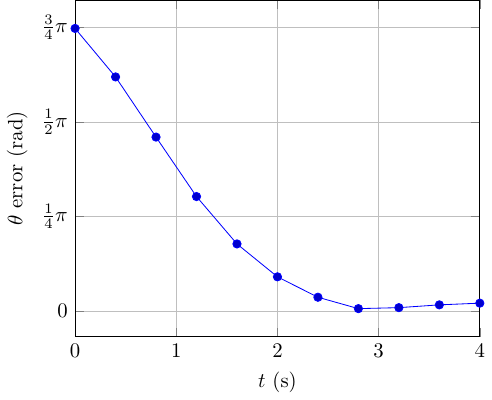

In [104]:
p = timeplot(t, θs; ylabel=L"$\theta$ error (rad)")
piticks!(p, 1//4, θs; axis=:y)
save_data && pgfsave(joinpath(datadir, "error.pdf"), p)
p

In [105]:
using RigidBodyDynamics

In [106]:
world = RigidBody{Float64}("world")
mechanism = Mechanism(world)
joint = Joint("joint", QuaternionSpherical{Float64}())
body = RigidBody{Float64}("body")
attach!(mechanism, world, body, joint);

In [107]:
using MeshCatMechanisms, MechanismGeometries, CoordinateTransformations, ColorTypes, GeometryTypes

In [108]:
struct SO3Geometry <: MechanismGeometries.AbstractGeometrySource end
function MechanismGeometries.visual_elements(mechanism::Mechanism, source::SO3Geometry)
    @assert length(joints(mechanism)) == 1
    joint = first(joints(mechanism))
    frame = frame_after(joint)
    elements = Vector{VisualElement}()
    boxdims = Vec(0.3, 0.3, 0.3)
    box = HyperRectangle(-boxdims / 2, boxdims)
    push!(elements, VisualElement(frame, box, MechanismGeometries.DEFAULT_COLOR, IdentityTransformation()))
    elements
end

In [109]:
mvis = MechanismVisualizer(mechanism, SO3Geometry());

In [110]:
open(mvis);

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8706
└ @ MeshCat /home/twan/.julia/packages/MeshCat/rjDJh/src/servers.jl:12
┌ Info: Listening on: Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 0x2202)
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:307


In [111]:
setanimation!(mvis, t, qs)

┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8706:8706 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366
┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8706:8706 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366
┌ Info: Accept:  🔗    0↑     0↓    0s 127.0.0.1:8706:8706 ≣16
└ @ HTTP.Servers /home/twan/.julia/packages/HTTP/nUK4f/src/Servers.jl:366


In [112]:
normalize.(τs)

10-element Array{Array{Float64,1},1}:
 [-0.538905, 0.842238, 0.0147203] 
 [-0.538905, 0.842238, 0.0147203] 
 [0.538905, -0.842238, -0.0147204]
 [0.538905, -0.842238, -0.0147203]
 [0.538905, -0.842238, -0.0147203]
 [0.538905, -0.842238, -0.0147203]
 [0.538905, -0.842238, -0.0147203]
 [0.538905, -0.842238, -0.0147203]
 [0.538905, -0.842238, -0.0147203]
 [0.538905, -0.842238, -0.0147203]